# BoneawareAI

Authors: Karthik Subramanian, Charles Green, Sai Anurag Pichika, Saarang Prabhuram


## Setup

### Load Extensions

Before getting started we need to run some standard code to set up our environment. You'll need to execute this code again each time you start the notebook.

First, run this cell to load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This enables us to modify `.py` source files and reintegrate them into the notebook, ensuring a smooth editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 25 11:37:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.17                 Driver Version: 561.17         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1060      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8              3W /   78W |       0MiB /   6144MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 17.0 gigabytes of available RAM

Not using a high-RAM runtime


### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!).

In [5]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [168]:
import os
PROJECT_PATH = 'BoneawareAI'
GOOGLE_DRIVE_PATH = f'/content/drive/MyDrive/{PROJECT_PATH}'
os.chdir(GOOGLE_DRIVE_PATH)
os.getcwd()

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/BoneawareAI'

In [169]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH) # this is important for the imports in the .py files to work

In [6]:
%pip install pyyaml==5.4.1
%pip install boto3
%pip install configparser
%pip install torch

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


### Local Setup OR Google Drive
Run the cell below regardless of whether you are using google drive or local setup.

In [7]:
# if running locally set GOOGLE PATH
import sys
isLocal = False
if 'google.colab' in sys.modules:
  print(f'Running in google colab. Our path is `{GOOGLE_DRIVE_PATH}`')
else:
  GOOGLE_DRIVE_PATH = '.'
  print('Running locally.')
  isLocal = True

Running locally.


### Imports

In [8]:
# RUN LOCALLY
import sys
if isLocal:
    sys.path.append('../src')  # Add the 'src' folder to Python's module search path
    sys.path.append('../datasets')  # Add the 'datasets' folder to Python's module search path
    sys.path.append('../notebooks')  # Add the 'notebooks' folder to Python's module search path
    print('Modules added correctly, locally.')
else:
    sys.path.append('src')  # Add the 'src' folder to Python's module search path
    sys.path.append('datasets')  # Add the 'datasets' folder to Python's module search path
    sys.path.append('notebooks')  # Add the 'notebooks' folder to Python's module search path
    print('Modules added correctly on colab.')

Modules added correctly, locally.


In [9]:
from image_utils import set_seed, MURADataset, load_data, confirm_images_and_labels, count_body_parts, count_positive_negative, count_body_parts_with_augmentations

c:\Users\green\anaconda3\envs\boneaware-ai\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [10]:
from metrics import plot_confusion_matrix, plot_roc_curve, compute_class_weights, calculate_metrics, calculate_metrics_per_body_part, evaluate_model

In [11]:
import torch

device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device = " + device)
if device == 'cpu':
    print("WARNING: Using CPU will cause slower train times")


Using device = cuda


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### Set Seed

This is so the results can be duplicated, ensure that the seed is set in the image_utils.py file, if you want a random seed, import random and set a random number

In [13]:
set_seed(42)

In [14]:
import os
import torch
import random
import numpy as np
import pandas as pd
from torch import nn, optim
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data Preprocessing
Get the dataset, perform data augmentation to get finalized MURA dataset

In [15]:
# Downloading MURA dataset and unzipping the file (this one takes time)
from data_loader import download_dataset
from constants import DATASETS_FOLDER, MURA_DATASET
from helpers.utils import unzip_file

if (isLocal):
    # Define the parent directory and dataset path
    parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Go to the parent directory
    datasets_folder = os.path.join(parent_dir, DATASETS_FOLDER)   # Define datasets folder in the parent directory
    dataset_path = os.path.join(datasets_folder, MURA_DATASET)    # Full path to the dataset file
else:
    datasets_folder = os.path.join(GOOGLE_DRIVE_PATH, DATASETS_FOLDER) # Define datasets folder in the parent directory
    dataset_path = os.path.join(datasets_folder, MURA_DATASET) # Full path to the dataset file

# Ensure the datasets folder exists
os.makedirs(datasets_folder, exist_ok=True)

# Check if the dataset is already downloaded
if not os.path.exists(dataset_path):
    print(f"{MURA_DATASET} not found in {DATASETS_FOLDER}. Downloading and extracting...")
    # Download and unzip the dataset
    download_dataset(MURA_DATASET, datasets_folder)
    unzip_file(dataset_path)
else:
    print(f"{MURA_DATASET} already exists in {DATASETS_FOLDER}. Skipping download.")

MURA-v1.1.zip already exists in datasets. Skipping download.


In [16]:
if (isLocal):
    data_dir = "../datasets/MURA-v1.1"
else:
    data_dir = os.path.join(datasets_folder, 'MURA-v1.1')

batch_size = 32

# Load training and validation data
train_loader, valid_loader = load_data(data_dir, batch_size=batch_size)

Loaded 147232 training samples and 3197 validation samples.


In [17]:
print("Training Data:")
for batch in train_loader:
    images, labels = batch
    print(f"Batch size: {len(images)}, Labels: {labels}")
    break

# Test the validation DataLoader
print("Validation Data:")
for images, labels in valid_loader:
    print(f"Batch size: {len(images)}, Labels: {labels}")
    break

Training Data:
Batch size: 32, Labels: tensor([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 1])
Validation Data:
Batch size: 32, Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [18]:
# Access the datasets from the DataLoaders
train_dataset = train_loader.dataset
valid_dataset = valid_loader.dataset

# Example: Print the length of the datasets
print(f"Number of samples in the training dataset: {len(train_dataset)}")
print(f"Number of samples in the validation dataset: {len(valid_dataset)}")

Number of samples in the training dataset: 147232
Number of samples in the validation dataset: 3197


In [19]:
#16 minutes to confirm on local, does not need to run as you can always use the dataset to confirm as well
#confirm_images_and_labels(train_dataset, "train")
#confirm_images_and_labels(valid_dataset, "valid")

In [20]:
count_body_parts(train_dataset, "train")
count_body_parts(valid_dataset, "valid")

Train dataset body part distribution:


BodyPart  Count
0     XR_WRIST   9752
1  XR_SHOULDER   8379
2      XR_HAND   5543
3    XR_FINGER   5106
4     XR_ELBOW   4931
5   XR_FOREARM   1825
6   XR_HUMERUS   1272

Valid dataset body part distribution:


BodyPart  Count
0     XR_WRIST    659
1  XR_SHOULDER    563
2     XR_ELBOW    465
3    XR_FINGER    461
4      XR_HAND    460
5   XR_FOREARM    301
6   XR_HUMERUS    288

In [21]:
# Example usage with 3 augmentations,  adjust the augmentations as needed
count_body_parts_with_augmentations(train_dataset, "train", num_augmentations=3)
count_body_parts_with_augmentations(valid_dataset, "valid", num_augmentations=3)

Train dataset body part distribution (with augmentations):


BodyPart  OriginalCount  AugmentedCount
0     XR_WRIST           9752           39008
1  XR_SHOULDER           8379           33516
2      XR_HAND           5543           22172
3    XR_FINGER           5106           20424
4     XR_ELBOW           4931           19724
5   XR_FOREARM           1825            7300
6   XR_HUMERUS           1272            5088

Valid dataset body part distribution (with augmentations):


BodyPart  OriginalCount  AugmentedCount
0     XR_WRIST            659            2636
1  XR_SHOULDER            563            2252
2     XR_ELBOW            465            1860
3    XR_FINGER            461            1844
4      XR_HAND            460            1840
5   XR_FOREARM            301            1204
6   XR_HUMERUS            288            1152

In [22]:
# Count positive/negative cases in the training dataset (with 3 augmentations)
count_positive_negative(train_dataset, "train", num_augmentations=3)

# Count positive/negative cases in the validation dataset (with 3 augmentations)
count_positive_negative(valid_dataset, "valid", num_augmentations=3)

Train dataset positive/negative distribution (with augmentations):


BodyPart  Negative  Positive  AugmentedNegative  AugmentedPositive
0     XR_ELBOW      2925      2006              11700               8024
1    XR_FINGER      3138      1968              12552               7872
2   XR_FOREARM      1164       661               4656               2644
3      XR_HAND      4059      1484              16236               5936
4   XR_HUMERUS       673       599               2692               2396
5  XR_SHOULDER      4211      4168              16844              16672
6     XR_WRIST      5765      3987              23060              15948

Valid dataset positive/negative distribution (with augmentations):


BodyPart  Negative  Positive  AugmentedNegative  AugmentedPositive
0     XR_ELBOW       235       230                940                920
1    XR_FINGER       214       247                856                988
2   XR_FOREARM       150       151                600                604
3      XR_HAND       271       189               1084                756
4   XR_HUMERUS       148       140                592                560
5  XR_SHOULDER       285       278               1140               1112
6     XR_WRIST       364       295               1456               1180

### Other Datasets

# Model

### DenseNet

In [23]:
from models.densenet import DenseNet

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the DenseNet
model = DenseNet(num_blocks=3, num_layers_per_block=4, growth_rate=32, reduction=0.5).to(device)


In [27]:
from sklearn.utils.class_weight import compute_class_weight

# Dynamically compute class weights
def compute_class_weights(dataset):
    """
    Computes class weights efficiently for binary classification.

    Args:
        dataset (Dataset): The training dataset.

    Returns:
        torch.Tensor: Class weights as a tensor.
    """
    # Extract labels from label_map
    labels = list(dataset.label_map.values())
    
    # Use scikit-learn to compute balanced class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    
    # Convert weights to a PyTorch tensor
    return torch.tensor(class_weights, dtype=torch.float)

In [28]:
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

# 6. Define Loss, Optimizer, and Scheduler
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

#optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# Compute class weights dynamically
class_weights = compute_class_weights(train_dataset).to(device)
# Define loss function with dynamic weights
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
# Define optimizer with adjusted weight decay
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# Use ReduceLROnPlateau for adaptive learning rate adjustment
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

#weights = torch.tensor([1.0, 3.0]).to(device)  # Adjust according to dataset imbalance
#criterion = nn.BCEWithLogitsLoss()


c:\Users\green\anaconda3\envs\boneaware-ai\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [30]:
print(f"Computed Class Weights: {class_weights}")

Computed Class Weights: tensor([0.8126, 1.2997], device='cuda:0')


In [29]:
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, classification_report,
    precision_recall_fscore_support, cohen_kappa_score, roc_curve
)

In [31]:
def train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs, device='cuda'):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    train_history = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}

    scaler = GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = valid_loader

            running_loss = 0.0
            running_corrects = 0

            progress_bar = tqdm(enumerate(loader), total=len(loader), desc=f"{phase} Progress")

            for i, (inputs, labels) in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    try:
                        with autocast(enabled=torch.cuda.is_available()):  # Mixed precision
                            outputs = model(inputs).view(-1)  # Ensure outputs have shape [batch_size]
                            labels = labels.view(-1)          # Ensure labels have shape [batch_size]
                            loss = criterion(outputs, labels)

                        if phase == 'train':
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()

                        preds = (outputs > 0.5).float()  # Convert logits to predictions
                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels)

                        progress_bar.set_postfix(loss=loss.item(), accuracy=(running_corrects.double() / ((i + 1) * inputs.size(0))).item())

                    except Exception as e:
                        print(f"Error in batch {i} of {phase}: {e}")
                        continue

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)

            train_history[f'{phase}_loss'].append(epoch_loss)
            train_history[f'{phase}_acc'].append(epoch_acc.item())

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                torch.save(model.state_dict(), f"best_model_epoch_{epoch+1}.pth")

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(epoch_loss)
        else:
            scheduler.step()

    print(f"Best Validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, train_history

In [32]:
# 8. Train the Model
model, train_history = train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs=10)

C:\Users\green\AppData\Local\Temp\ipykernel_16600\2192747544.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/10
----------


train Progress:   0%|          | 0/4601 [00:00<?, ?it/s]C:\Users\green\AppData\Local\Temp\ipykernel_16600\2192747544.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):  # Mixed precision
train Progress: 100%|██████████| 4601/4601 [30:44<00:00,  2.49it/s, accuracy=0.616, loss=0.67] 


train Loss: 0.7487 Acc: 0.6162


valid Progress: 100%|██████████| 100/100 [00:30<00:00,  3.29it/s, accuracy=0.645, loss=0.383]


valid Loss: 0.7644 Acc: 0.5852
Epoch 2/10
----------


train Progress: 100%|██████████| 4601/4601 [31:17<00:00,  2.45it/s, accuracy=0.671, loss=0.709]


train Loss: 0.6954 Acc: 0.6715


valid Progress: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s, accuracy=0.706, loss=0.458]


valid Loss: 0.7132 Acc: 0.6406
Epoch 3/10
----------


train Progress: 100%|██████████| 4601/4601 [31:01<00:00,  2.47it/s, accuracy=0.699, loss=0.793]


train Loss: 0.6636 Acc: 0.6993


valid Progress: 100%|██████████| 100/100 [00:30<00:00,  3.28it/s, accuracy=0.706, loss=0.193]


valid Loss: 0.8242 Acc: 0.6406
Epoch 4/10
----------


train Progress: 100%|██████████| 4601/4601 [31:14<00:00,  2.45it/s, accuracy=0.715, loss=0.749]


train Loss: 0.6420 Acc: 0.7150


valid Progress: 100%|██████████| 100/100 [00:29<00:00,  3.34it/s, accuracy=0.711, loss=0.21]


valid Loss: 0.8301 Acc: 0.6450
Epoch 5/10
----------


train Progress: 100%|██████████| 4601/4601 [30:36<00:00,  2.51it/s, accuracy=0.726, loss=0.509]


train Loss: 0.6277 Acc: 0.7256


valid Progress: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s, accuracy=0.739, loss=0.276]


valid Loss: 0.7268 Acc: 0.6706
Epoch 6/10
----------


train Progress: 100%|██████████| 4601/4601 [30:39<00:00,  2.50it/s, accuracy=0.734, loss=0.405]


train Loss: 0.6147 Acc: 0.7343


valid Progress: 100%|██████████| 100/100 [00:29<00:00,  3.39it/s, accuracy=0.721, loss=0.2]  


valid Loss: 0.8321 Acc: 0.6541
Epoch 7/10
----------


train Progress: 100%|██████████| 4601/4601 [30:42<00:00,  2.50it/s, accuracy=0.74, loss=0.464] 


train Loss: 0.6050 Acc: 0.7401


valid Progress: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s, accuracy=0.744, loss=0.198]


valid Loss: 0.7694 Acc: 0.6753
Epoch 8/10
----------


train Progress: 100%|██████████| 4601/4601 [31:02<00:00,  2.47it/s, accuracy=0.745, loss=0.604]


train Loss: 0.5978 Acc: 0.7445


valid Progress: 100%|██████████| 100/100 [00:30<00:00,  3.28it/s, accuracy=0.782, loss=0.434]


valid Loss: 0.6503 Acc: 0.7097
Epoch 9/10
----------


train Progress: 100%|██████████| 4601/4601 [30:45<00:00,  2.49it/s, accuracy=0.75, loss=0.491] 


train Loss: 0.5898 Acc: 0.7501


valid Progress: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s, accuracy=0.786, loss=0.342]


valid Loss: 0.6826 Acc: 0.7125
Epoch 10/10
----------


train Progress: 100%|██████████| 4601/4601 [30:37<00:00,  2.50it/s, accuracy=0.755, loss=0.719]


train Loss: 0.5825 Acc: 0.7549


valid Progress: 100%|██████████| 100/100 [00:30<00:00,  3.27it/s, accuracy=0.747, loss=0.131]

valid Loss: 0.8843 Acc: 0.6772
Best Validation Accuracy: 0.7125


In [ ]:
model_name = 'densenet_mura_2_cg.pth'
#model_name = 'best_model_epoch_9.pth'
# Save the model
#torch.save(model.state_dict(), model_name)
# Load the model
if device == 'cuda':
    model.load_state_dict(torch.load(model_name))
elif device == 'mps':
    model.load_state_dict(torch.load(model_name, map_location=torch.device('mps')))
else:
    model.load_state_dict(torch.load(model_name, map_location=torch.device('cpu')))
# Evaluate on validation set
model.eval()

C:\Users\green\AppData\Local\Temp\ipykernel_16600\2145558714.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name, map_location=t

DenseNet(
  (init_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (features): Sequential(
    (0): DenseBlock(
      (block): Sequential(
        (0): DenseLayer(
          (layer): Sequential(
            (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (3): Dropout(p=0.2, inplace=False)
          )
        )
        (1): DenseLayer(
          (layer): Sequential(
            (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(96, 32, kernel_size=(3, 3), stri

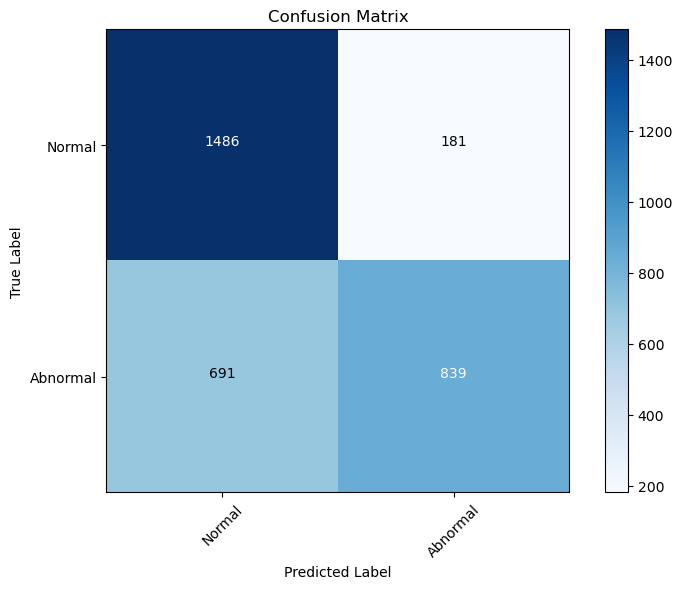

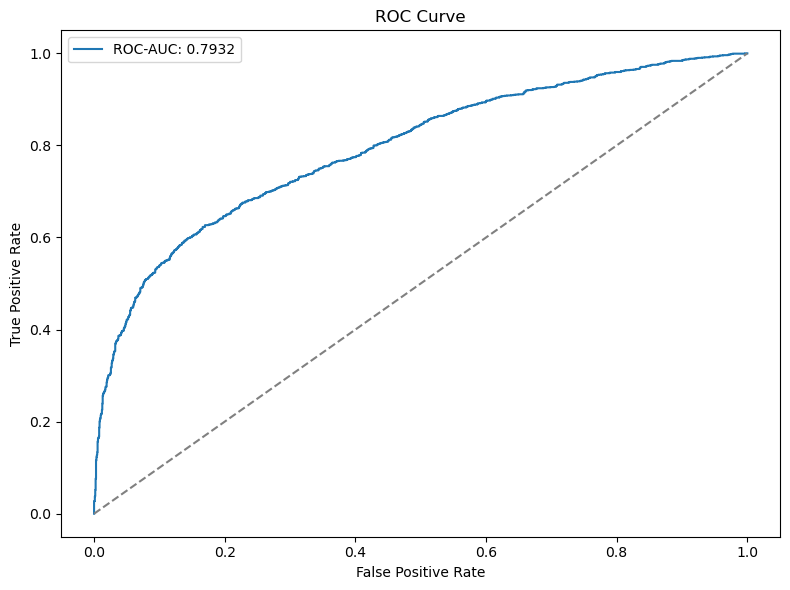

Global Metrics:
{'Accuracy': 0.727244291523303, 'Precision': 0.8225490196078431, 'Recall': 0.5483660130718955, 'F1 Score': 0.6580392156862745, 'Specificity': 0.8914217156568687, 'ROC-AUC': 0.7932123379245719, "Cohen's Kappa": 0.4458952724526202, 'Kappa 95% CI Lower': 0.4226860230309061, 'Kappa 95% CI Upper': 0.46910452187433427, 'Loss': 0.6826903004552336}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.89      0.77      1667
         1.0       0.82      0.55      0.66      1530

    accuracy                           0.73      3197
   macro avg       0.75      0.72      0.72      3197
weighted avg       0.75      0.73      0.72      3197

Metrics per body part:
             Accuracy  Precision    Recall  F1 Score  Specificity   ROC-AUC  \
XR_WRIST     0.757208   0.860963  0.545763  0.668050     0.928571  0.860989   
XR_FOREARM   0.767442   0.917526  0.589404  0.717742     0.946667  0.814923   
XR_HAND      0.682609   0.75903

Accuracy  Precision    Recall  F1 Score  Specificity   ROC-AUC  \
0  0.727244   0.822549  0.548366  0.658039     0.891422  0.793212   

   Cohen's Kappa  Kappa 95% CI Lower  Kappa 95% CI Upper     Loss  
0       0.445895            0.422686            0.469105  0.68269

In [36]:
# Evaluate on validation set
metrics = evaluate_model(model, valid_loader, dataset=valid_dataset, criterion=criterion)
display(metrics)

## Visualizations

In [37]:
from visualizer import find_last_conv_layer, run_gradcam, GradCAM, run_gradcam_filtered, run_gradcam_for_path_person_or_bodypart

In [38]:
layer_name, target_layer = find_last_conv_layer(model)
print(layer_name)
print(target_layer)


features.4.block.3.layer.2
Conv2d(208, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


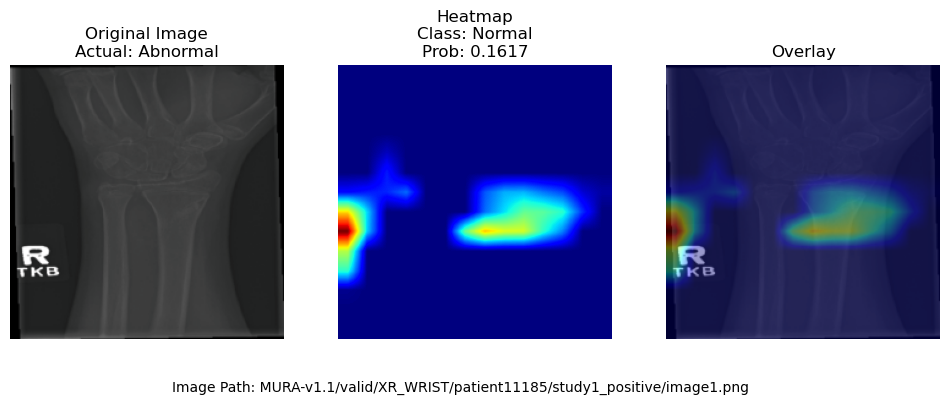

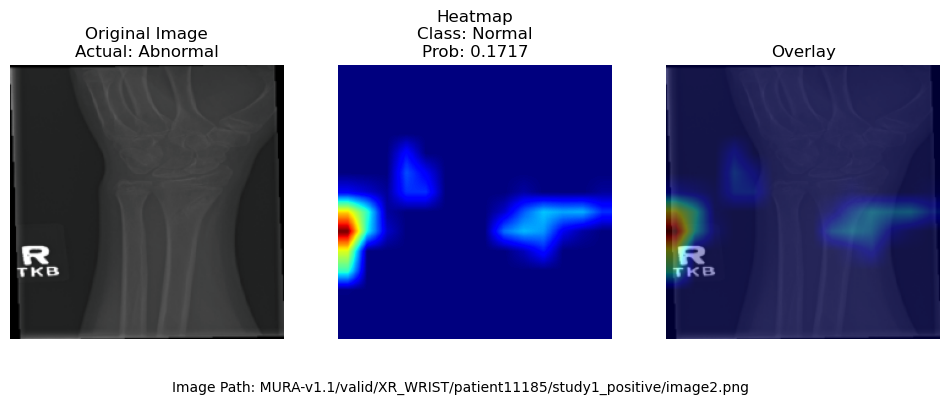

In [39]:
#Generates minimum n images or batch size images from first batch
run_gradcam(model, valid_loader, target_layer, class_names=["Normal", "Abnormal"], device=device, num_images=2)

In [40]:
body_parts = ["XR_ELBOW", "XR_FINGER", "XR_FOREARM", "XR_HAND", "XR_HUMERUS", "XR_SHOULDER", "XR_WRIST"]

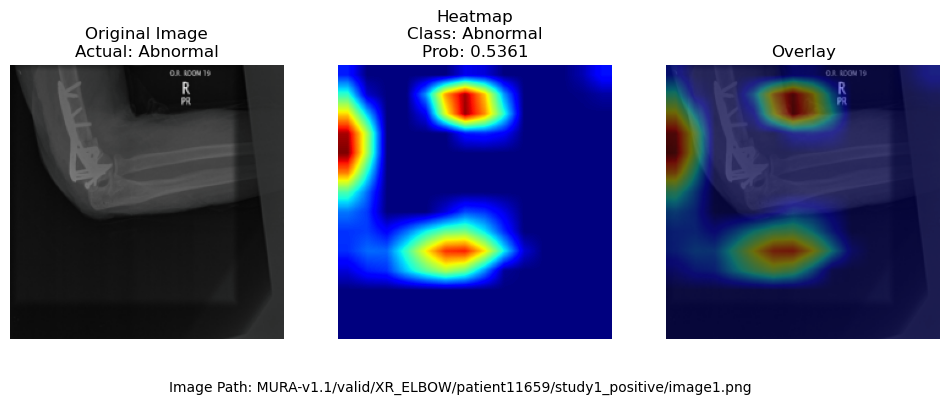

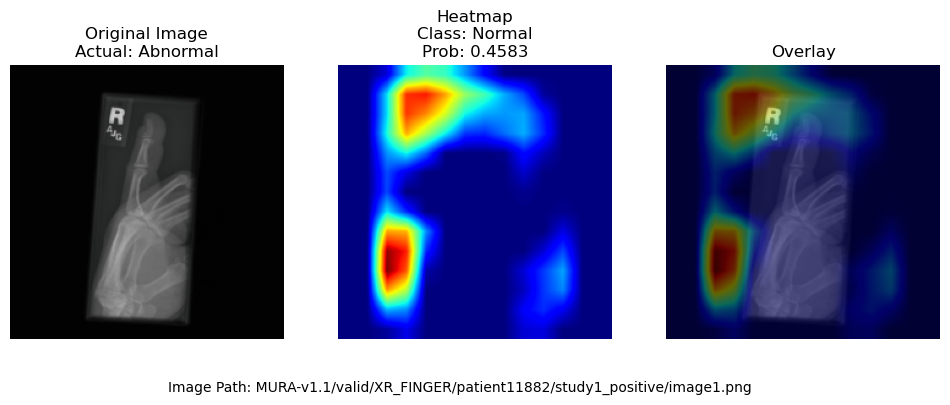

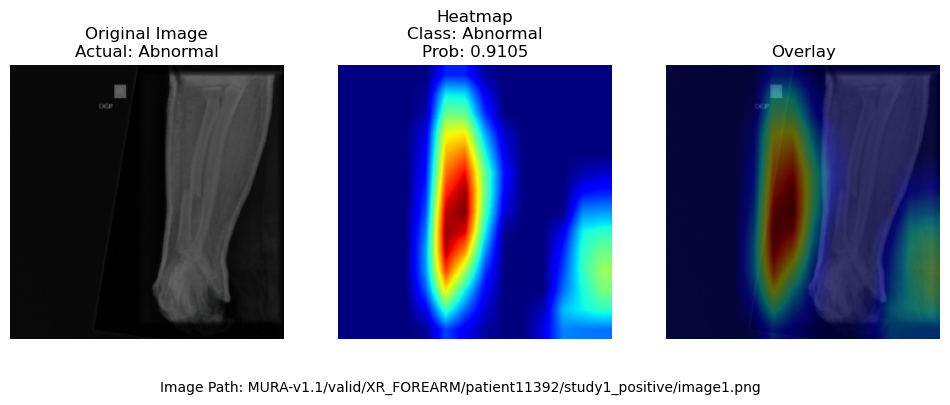

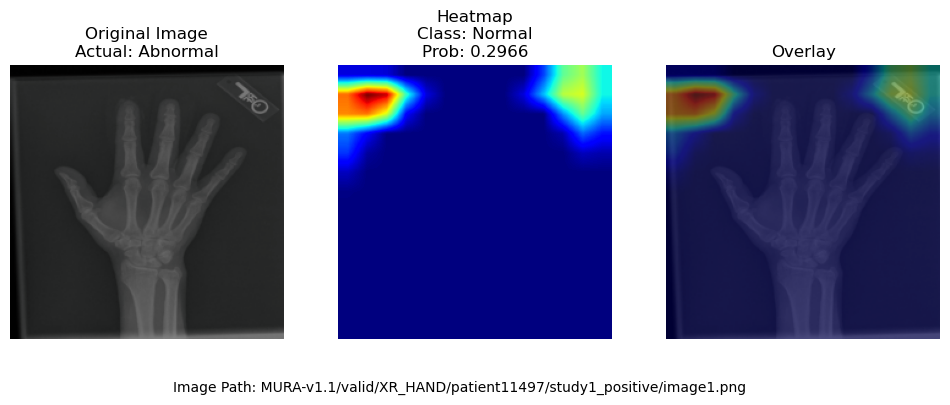

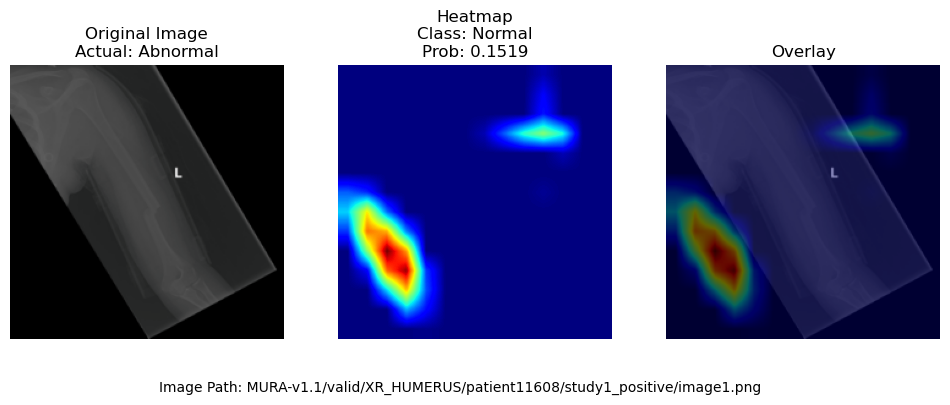

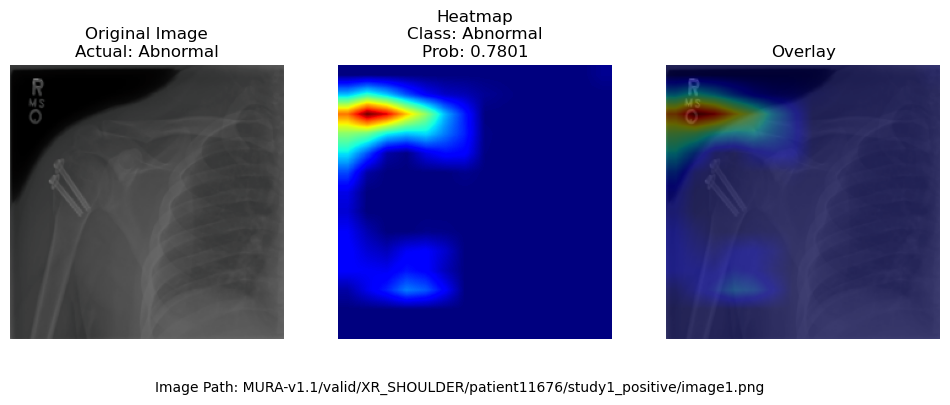

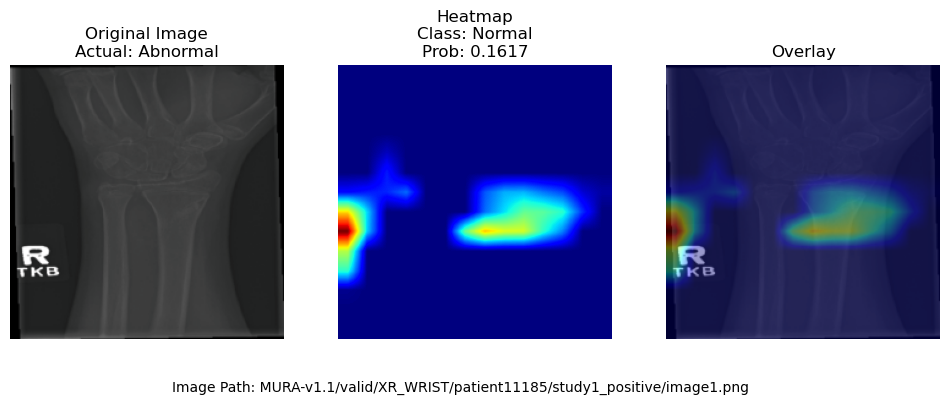

In [41]:
#Get 3 images from each bodypart
for x in body_parts:
    run_gradcam_filtered(
        model=model,
        dataloader=valid_loader,
        target_layer=target_layer,
        class_names=["Normal", "Abnormal"],
        body_part=x,
        n=1,
        device=device
    )

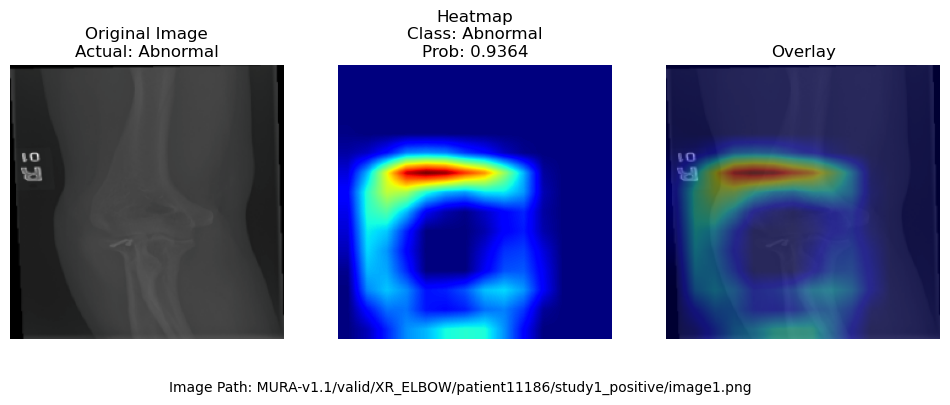

In [42]:
#Specific Image Path, must have these slashes /
run_gradcam_for_path_person_or_bodypart(
    model=model,
    dataloader=valid_loader,
    target_layer=target_layer,
    class_names=["Normal", "Abnormal"],
    image_path="MURA-v1.1/valid/XR_ELBOW/patient11186/study1_positive/image1.png",
    device=device
)

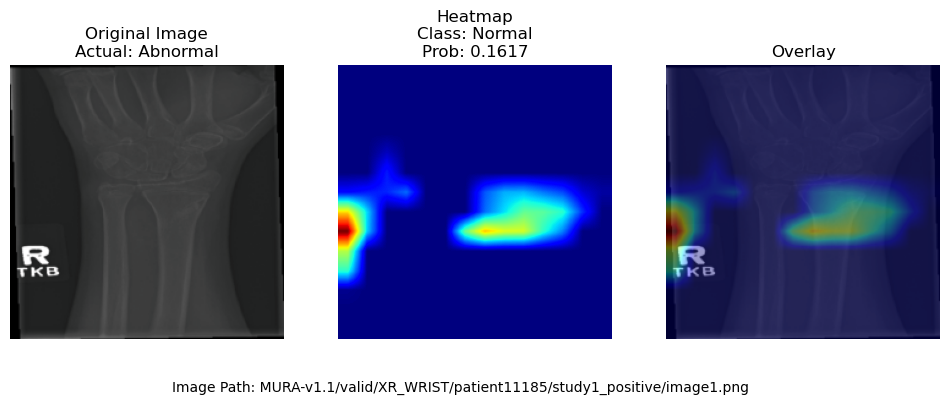

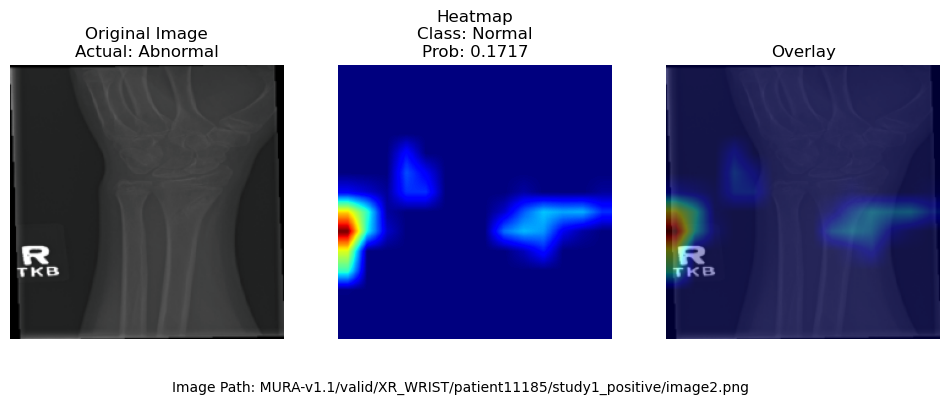

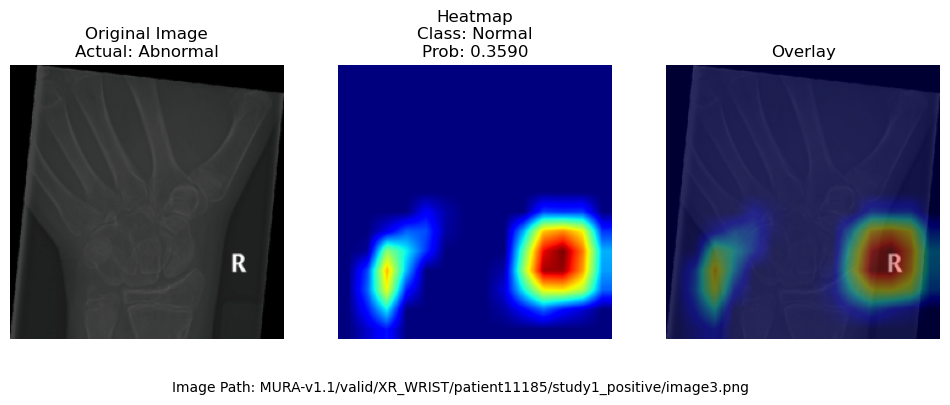

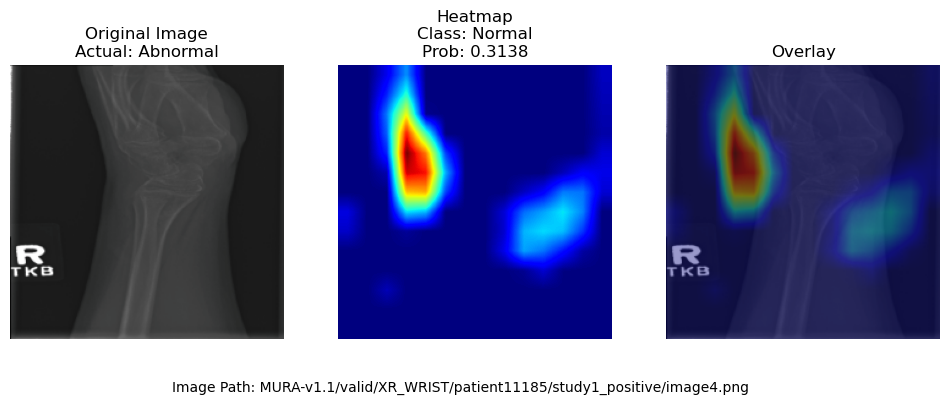

In [43]:
#Specific Body Part on a Person
run_gradcam_for_path_person_or_bodypart(
    model=model,
    dataloader=valid_loader,
    target_layer=target_layer,
    class_names=["Normal", "Abnormal"],
    person_id="patient11185",
    body_part="XR_WRIST",
    device=device
)


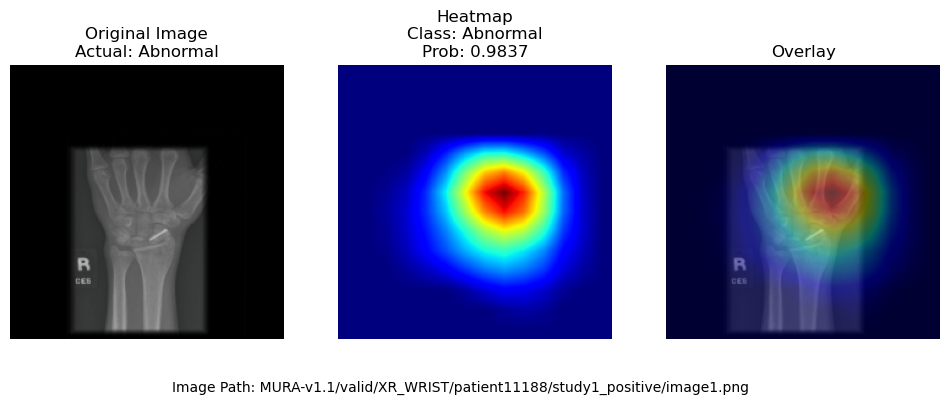

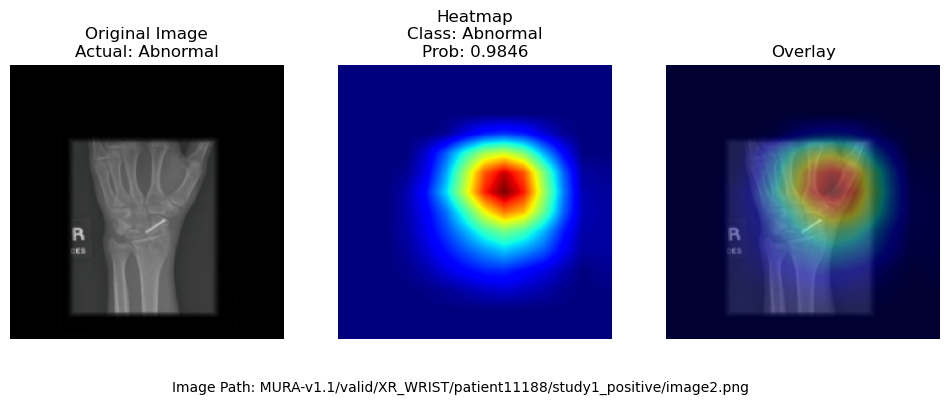

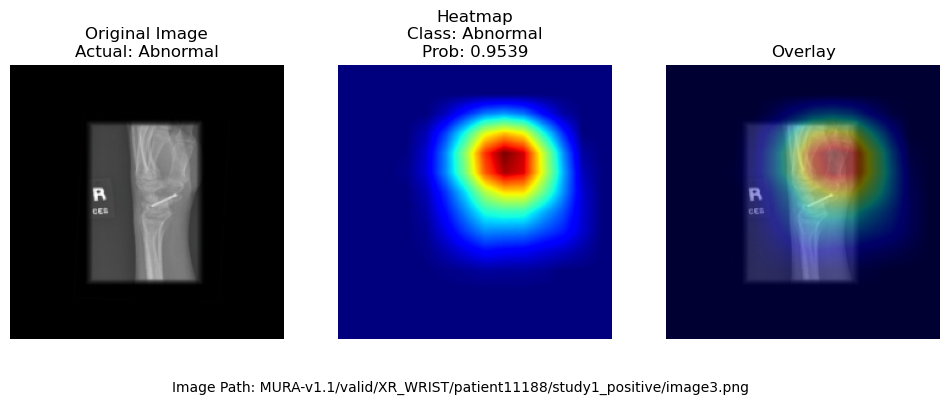

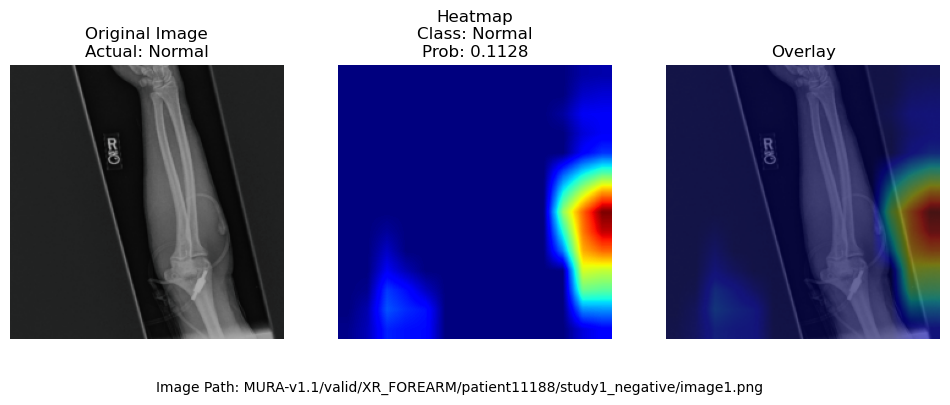

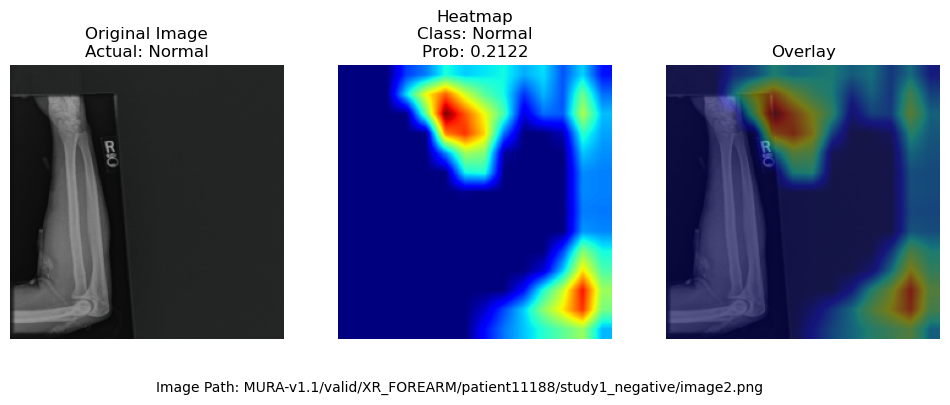

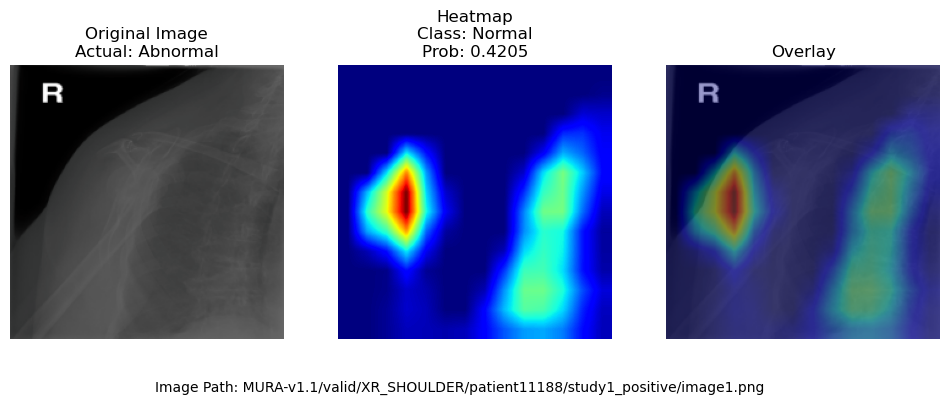

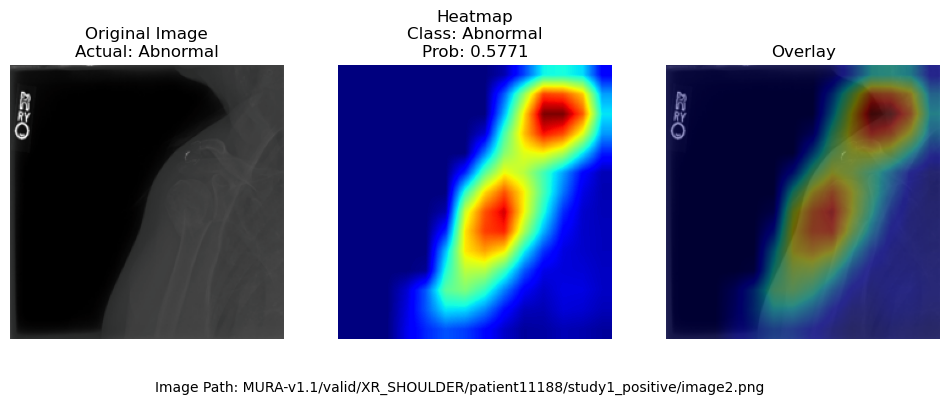

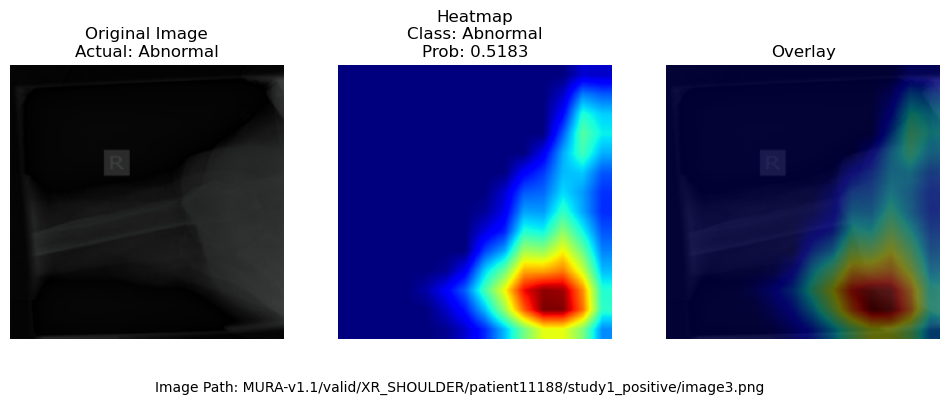

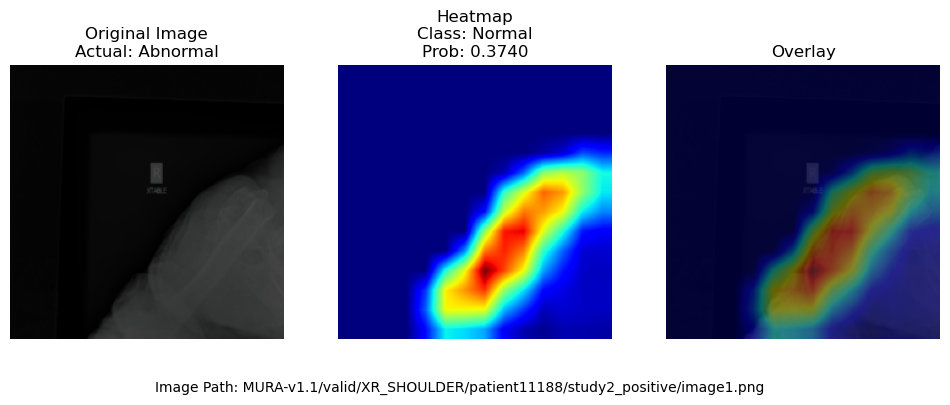

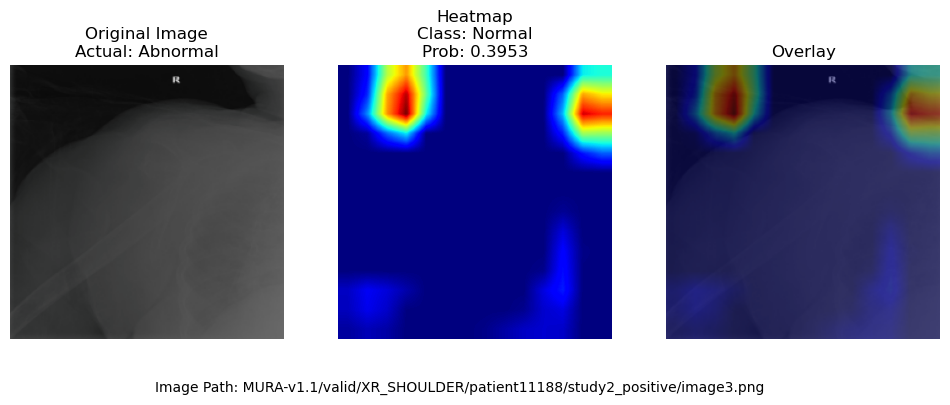

In [160]:
#Specific Person
run_gradcam_for_path_person_or_bodypart(
    model=model,
    dataloader=valid_loader,
    target_layer=target_layer,
    class_names=["Normal", "Abnormal"],
    person_id="patient11188",
    device=device
)
